## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

save_dir = "./checkpoint"
file_name = save_dir + "/D86_HW.h5"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## save_best_only = False

In [8]:
model_ckpt = ModelCheckpoint(filepath=file_name, 
                             monitor="val_loss", 
                             save_best_only=False)

optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt], 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 - 6s - loss: 2.2083 - accuracy: 0.2724 - val_loss: 2.1616 - val_accuracy: 0.1696 - 6s/epoch - 118ms/step
Epoch 2/50
49/49 - 4s - loss: 1.7404 - accuracy: 0.3925 - val_loss: 1.9756 - val_accuracy: 0.2889 - 4s/epoch - 74ms/step
Epoch 3/50
49/49 - 4s - loss: 1.6144 - accuracy: 0.4331 - val_loss: 1.8361 - val_accuracy: 0.3549 - 4s/epoch - 73ms/step
Epoch 4/50
49/49 - 3s - loss: 1.5415 - accuracy: 0.4584 - val_loss: 1.7423 - val_accuracy: 0.3812 - 3s/epoch - 71ms/step
Epoch 5/50
49/49 - 4s - loss: 1.4863 - accuracy: 0.4783 - val_loss: 1.6869 - val_accuracy: 0.3989 - 4s/epoch - 73ms/step
Epoch 6/50
49/49 - 3s - loss: 1.4402 - accuracy: 0.4960 - val_loss: 1.6057 - val_accuracy: 0.4355 - 3s/epoch - 71ms/step
Epoch 7/50
49/49 - 4s - loss: 1.4005 - accuracy: 0.5074 - val_loss: 1.5729 - val_accuracy: 0.4424 - 4s/epoch - 74ms/step
Epoch 8/50
49/49 - 4s - loss: 1.3663 - accuracy: 0.5213 - val_loss: 1.5301 - val_accuracy: 0.4539 - 4s/epoch - 72ms/step
Epoch 9/50
49/49 - 4s - loss: 1

In [9]:
model = keras.models.load_model(file_name)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6883 - accuracy: 0.4801


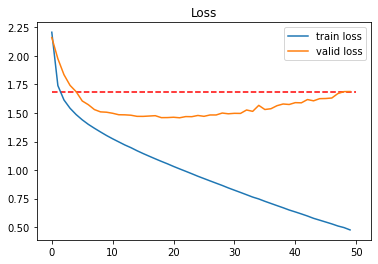

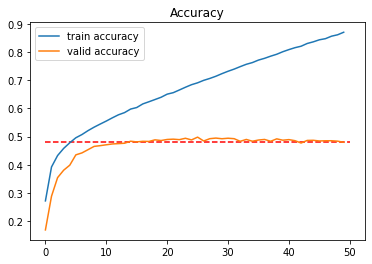

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## save_best_only = True, save_weights_only = True

In [11]:
model = build_mlp(input_shape=x_train.shape[1:])

file_name = save_dir + "/D86_HW_weight.h5"
model_ckpt = ModelCheckpoint(filepath=file_name, 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)

optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt], 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 - 4s - loss: 2.2386 - accuracy: 0.2739 - val_loss: 2.1237 - val_accuracy: 0.1891 - 4s/epoch - 88ms/step
Epoch 2/50
49/49 - 3s - loss: 1.7371 - accuracy: 0.3975 - val_loss: 1.9873 - val_accuracy: 0.2674 - 3s/epoch - 69ms/step
Epoch 3/50
49/49 - 4s - loss: 1.6148 - accuracy: 0.4357 - val_loss: 1.8445 - val_accuracy: 0.3402 - 4s/epoch - 72ms/step
Epoch 4/50
49/49 - 4s - loss: 1.5401 - accuracy: 0.4635 - val_loss: 1.7277 - val_accuracy: 0.4003 - 4s/epoch - 74ms/step
Epoch 5/50
49/49 - 4s - loss: 1.4866 - accuracy: 0.4819 - val_loss: 1.6442 - val_accuracy: 0.4245 - 4s/epoch - 73ms/step
Epoch 6/50
49/49 - 4s - loss: 1.4398 - accuracy: 0.4977 - val_loss: 1.5852 - val_accuracy: 0.4400 - 4s/epoch - 72ms/step
Epoch 7/50
49/49 - 4s - loss: 1.4006 - accuracy: 0.5134 - val_loss: 1.5446 - val_accuracy: 0.4568 - 4s/epoch - 74ms/step
Epoch 8/50
49/49 - 4s - loss: 1.3649 - accuracy: 0.5249 - val_loss: 1.5160 - val_accuracy: 0.4661 - 4s/epoch - 74ms/step
Epoch 9/50
49/49 - 4s - loss: 1.

In [12]:
from sklearn.metrics import accuracy_score

new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy before loadback: %.3f" % new_model_acc)

new_model.load_weights(file_name)
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy after loadback: %.3f" % new_model_acc)

Accuracy before loadback: 0.100
Accuracy after loadback: 0.492
